In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from util import *

In [39]:
# set global path
PATH = '/home/canliu/ENL_NetDissect/patches_VAE/MIT_ImageRatings'
INDEXFILE = 'MIT_ImageRatings.csv'
IMAGEPATH = 'All_other_MIT_images'
STRIDE = 60
PSIZE = 64
PROW = 19
PCOL = 14

In [3]:
# get natrualness rating
image_to_score = load_index(file_path = PATH, index_path = INDEXFILE)
print("number of images: {}".format(len(list(image_to_score.keys()))))

# clean the list (some images do not exist)
sorted_image_to_score = []
for image in image_to_score:
    image_path = os.path.join(PATH, IMAGEPATH, image)
    if os.path.exists(image_path):
        sorted_image_to_score.append((image_to_score[image], image))
sorted_image_to_score.sort()
print("number of existing images: {}".format(len(sorted_image_to_score)))

number of images: 1105
number of existing images: 1030


offset: 18


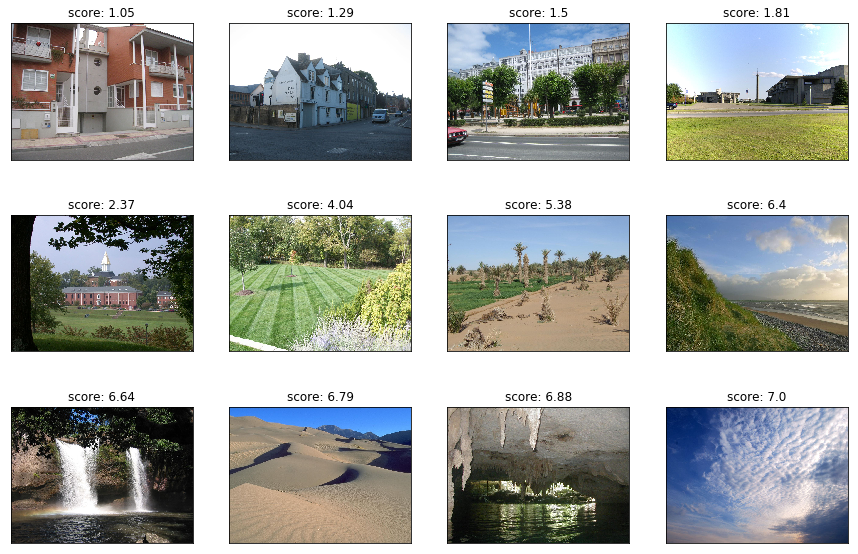

In [4]:
# some of the images
import random
offset = random.randint(0, 20)
print("offset: {}".format(offset))
fig = plt.figure(figsize = (15, 10))
for i, rank in enumerate(range(0, 1030, 90)):
    image = sorted_image_to_score[rank + offset]
    image_path = os.path.join(PATH, IMAGEPATH, image[1])
    fig.add_subplot(3, 4, i + 1, yticks = [], xticks = [], title = "score: {}".format(image[0]))
    plt.imshow(plt.imread(image_path))
plt.show()

In [216]:
# select 10 most urban images & 10 most natural images
most_urbans = [sorted_image_to_score[i] for i in range(5)]
most_natures = [sorted_image_to_score[i] for i in range(-5, 0)]

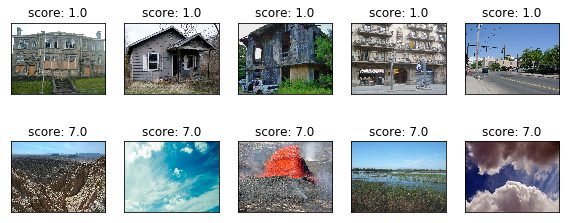

In [217]:
# visualize
fig = plt.figure(figsize = (20, 4))
for i, image in enumerate(most_urbans):
    image_path = os.path.join(PATH, IMAGEPATH, image[1])
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [], title = "score: {}".format(image[0]))
    plt.imshow(plt.imread(image_path))

for i, image in enumerate(most_natures):
    image_path = os.path.join(PATH, IMAGEPATH, image[1])
    fig.add_subplot(2, 10, i + 11, yticks = [], xticks = [], title = "score: {}".format(image[0]))
    plt.imshow(plt.imread(image_path))
plt.show()

In [218]:
base_dir = '/scratch/midway2/canliu'
GRAM_PATH = os.path.join(base_dir, 'grams')
CLASSES = ['urban', 'neutral', 'nature']
DIMS = {'conv1_1': 64 * 64,
       'pool1': 64 * 64,
       'pool2': 128 * 128,
       'pool3': 256 * 256,
       'pool4': 512 * 512}

In [219]:
def load_gram(handpick = None, gram_path = GRAM_PATH, layer = 'conv1_1', classes = CLASSES, cutoff = None):
    df = []
    idx = 0
    for i, cls in enumerate(classes):
        grams = []
        print("class: {}".format(cls))
        if handpick:
            files = handpick[i]
            files = [os.path.join(gram_path, cls, f[1].split('.')[0] + '.npz') for f in files]
        else:
            files = sorted(glob.glob(os.path.join(gram_path, cls) + "/*"))
        if cutoff:
            files = files[:cutoff]
        for f in files:
            print(f)
            gram = np.load(f)
            for key in gram.keys():
                if key.endswith(layer):
                    layer_gram = gram[key].flatten()
                    grams.append(layer_gram)
        grams_df = pd.DataFrame(grams, index = list(range(idx, idx + len(grams))))
        grams_df['class'] = cls
        df.append(grams_df)
        idx += len(grams)
    return pd.concat(df)

In [220]:
# load data into Pandas DataFrame
layer = 'pool1'
grams_df = load_gram(handpick = [most_urbans, most_natures], layer = layer, classes = ['urban', 'nature'])

class: urban
/scratch/midway2/canliu/grams/urban/2915825346_8ab54dee48_o.npz
/scratch/midway2/canliu/grams/urban/4477947944_a4808e0f07_o.npz
/scratch/midway2/canliu/grams/urban/9232732578_68f25ea0fe_o.npz
/scratch/midway2/canliu/grams/urban/labelme_bwccfvgaubpcgkv.npz
/scratch/midway2/canliu/grams/urban/labelme_calrsncqddcdefi.npz
class: nature
/scratch/midway2/canliu/grams/nature/sun_bvyxtpthsxbigblb.npz
/scratch/midway2/canliu/grams/nature/sun_bwbqkloviocxctfm.npz
/scratch/midway2/canliu/grams/nature/sun_bxuxfuwbccpvufhi.npz
/scratch/midway2/canliu/grams/nature/sun_byjtronwcohqmfbh.npz
/scratch/midway2/canliu/grams/nature/sun_bzroiumpaljlxkjo.npz


In [221]:
patches = [gen_patches(img[1], file_path = PATH, image_path = IMAGEPATH, stride = STRIDE, psize = PSIZE) for img in most_urbans + most_natures] 

shape of patches: (19, 14, 64, 64, 3)
shape of patches: (19, 14, 64, 64, 3)
shape of patches: (19, 14, 64, 64, 3)
shape of patches: (19, 14, 64, 64, 3)
shape of patches: (19, 14, 64, 64, 3)
shape of patches: (19, 14, 64, 64, 3)
shape of patches: (19, 14, 64, 64, 3)
shape of patches: (19, 14, 64, 64, 3)
shape of patches: (19, 14, 64, 64, 3)
shape of patches: (19, 14, 64, 64, 3)


In [49]:
def compute_patches_row_col(ind, num_rol = PROW, num_col = PCOL):
    assert ind < num_rol * num_col
    return (ind // num_col, ind % num_col)

In [222]:
# Normalize the Data (mean = 0, variance = 1)
from sklearn.preprocessing import StandardScaler
x = grams_df.loc[:, list(range(DIMS[layer]))].values # gram matrix ~ features
print(x.shape)
y = grams_df.loc[:, ['class']].values  # class
x = StandardScaler().fit_transform(x) # standardized features

(2660, 4096)


In [172]:
x.shape

(532, 4096)

## 1 Urban + 1 Nature + conv1_1

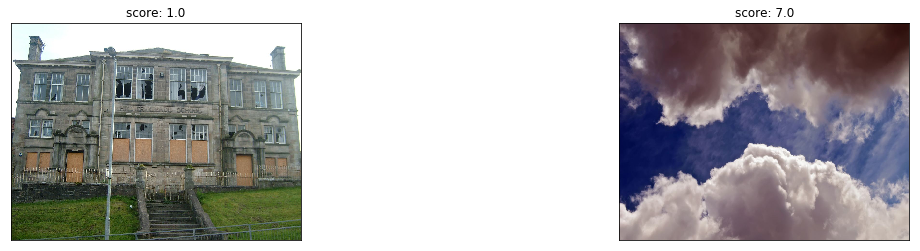

In [72]:
# use 1 urban and 1 nature images
fig = plt.figure(figsize = (20, 4))
for i, image in enumerate(most_urbans):
    image_path = os.path.join(PATH, IMAGEPATH, image[1])
    fig.add_subplot(1, 2, i + 1, yticks = [], xticks = [], title = "score: {}".format(image[0]))
    plt.imshow(plt.imread(image_path))

for i, image in enumerate(most_natures):
    image_path = os.path.join(PATH, IMAGEPATH, image[1])
    fig.add_subplot(1, 2, i + 2, yticks = [], xticks = [], title = "score: {}".format(image[0]))
    plt.imshow(plt.imread(image_path))
plt.show()

### PCA

In [173]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(x)

In [174]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

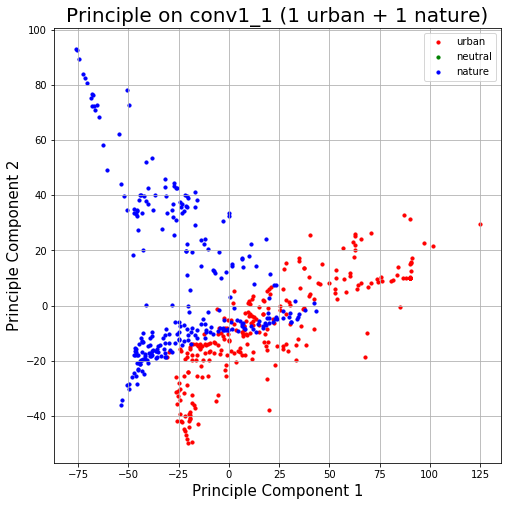

In [175]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principle Component 1', fontsize = 15)
ax.set_ylabel('Principle Component 2', fontsize = 15)
ax.set_title('Principle on conv1_1 (1 urban + 1 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

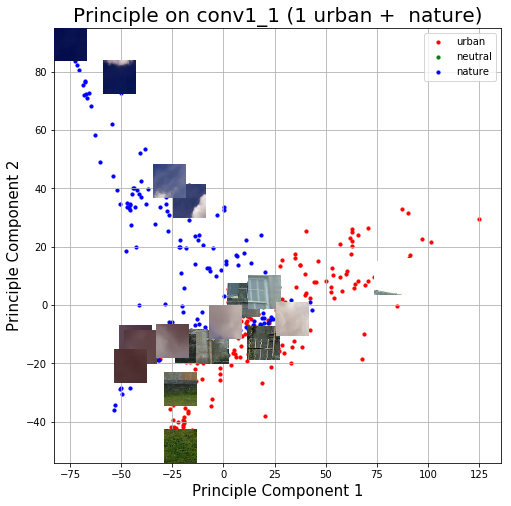

In [176]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principle Component 1', fontsize = 15)
ax.set_ylabel('Principle Component 2', fontsize = 15)
ax.set_title('Principle on conv1_1 (1 urban +  nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

chosen_patches = []
interval = merge_df.shape[0] // 20

for i in range(20):
    img_num = np.random.randint(i * interval, (i + 1) * interval)  # choose uniformly from each image
    #print("img_num: {}".format(img_num))
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    #print("img id: {} patch num: {}".format(img_id, img_num))
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    chosen_patches.append(img)
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

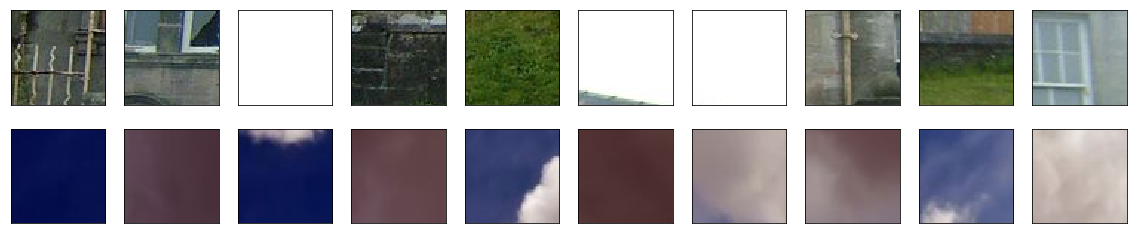

In [177]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

### ICA

In [178]:
from sklearn.decomposition import FastICA 
ICA = FastICA(n_components=2, random_state=12) 
components = ICA.fit_transform(x)

/home/canliu/.conda/envs/fastai/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [179]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

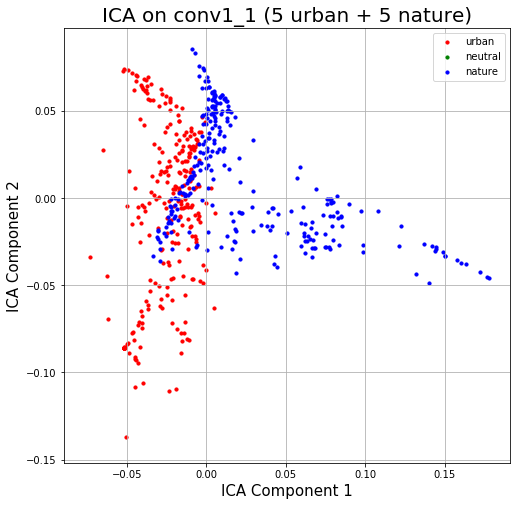

In [180]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('ICA Component 1', fontsize = 15)
ax.set_ylabel('ICA Component 2', fontsize = 15)
ax.set_title('ICA on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

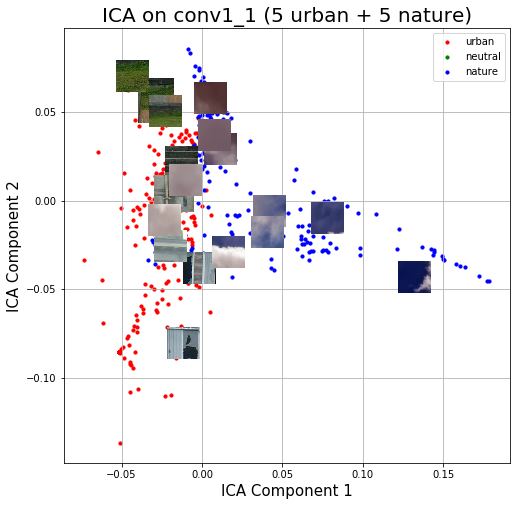

In [182]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('ICA Component 1', fontsize = 15)
ax.set_ylabel('ICA Component 2', fontsize = 15)
ax.set_title('ICA on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

chosen_patches = []
interval = merge_df.shape[0] // 20

for i in range(20):
    img_num = np.random.randint(i * interval, (i + 1) * interval)  # choose uniformly from each image
    #print("img_num: {}".format(img_num))
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    #print("img id: {} patch num: {}".format(img_id, img_num))
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    chosen_patches.append(img)
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

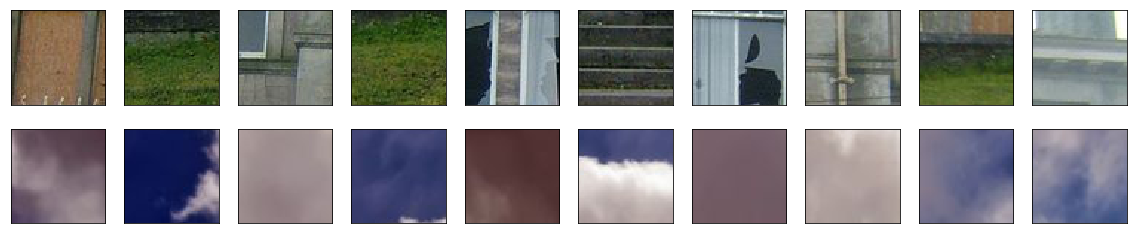

In [183]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

### Factor Analysis

In [211]:
from sklearn.decomposition import FactorAnalysis
FA= FactorAnalysis(n_components = 2)
components = FA.fit_transform(x)

In [212]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

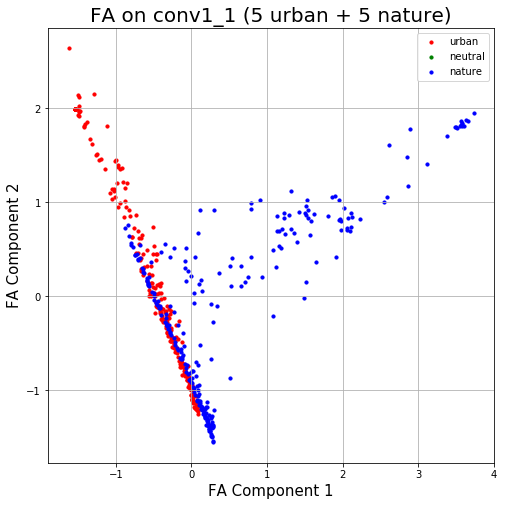

In [213]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('FA Component 1', fontsize = 15)
ax.set_ylabel('FA Component 2', fontsize = 15)
ax.set_title('FA on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

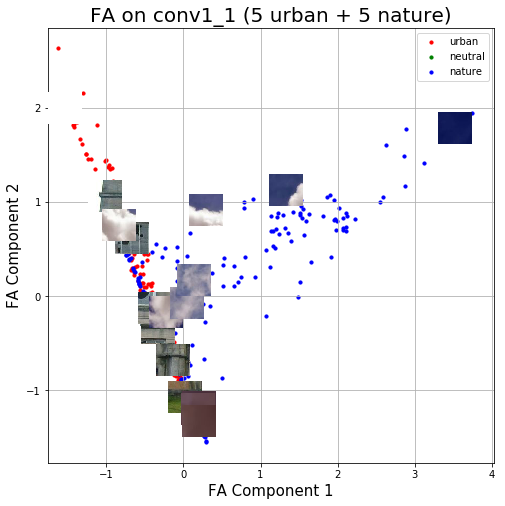

In [214]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('FA Component 1', fontsize = 15)
ax.set_ylabel('FA Component 2', fontsize = 15)
ax.set_title('FA on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

chosen_patches = []
interval = merge_df.shape[0] // 20

for i in range(20):
    img_num = np.random.randint(i * interval, (i + 1) * interval)  # choose uniformly from each image
    #print("img_num: {}".format(img_num))
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    #print("img id: {} patch num: {}".format(img_id, img_num))
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    chosen_patches.append(img)
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

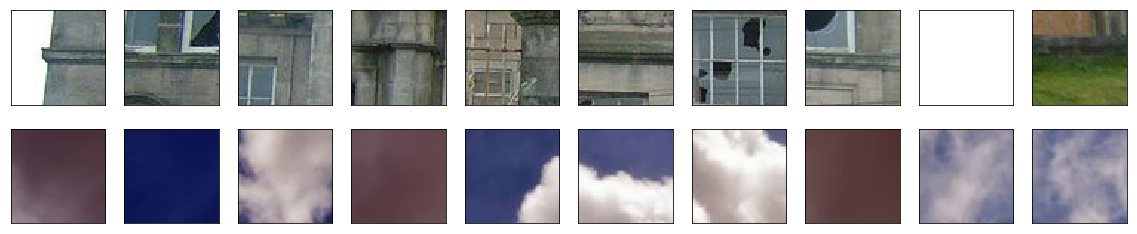

In [215]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

### Isomap

In [208]:
from sklearn import manifold 
IM = manifold.Isomap(n_neighbors=5, n_components=2, n_jobs=-1)
components = IM.fit_transform(x)

In [209]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

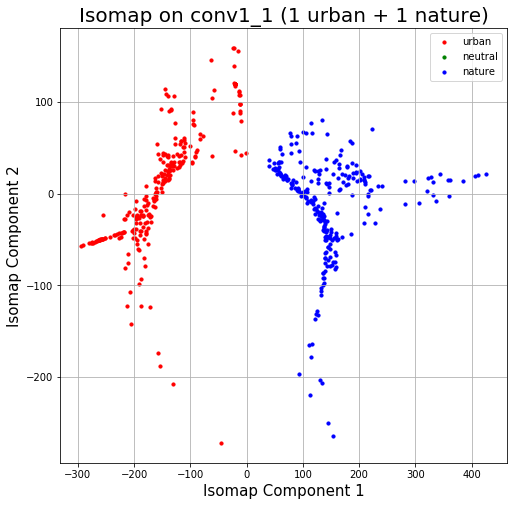

In [210]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Isomap Component 1', fontsize = 15)
ax.set_ylabel('Isomap Component 2', fontsize = 15)
ax.set_title('Isomap on conv1_1 (1 urban + 1 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

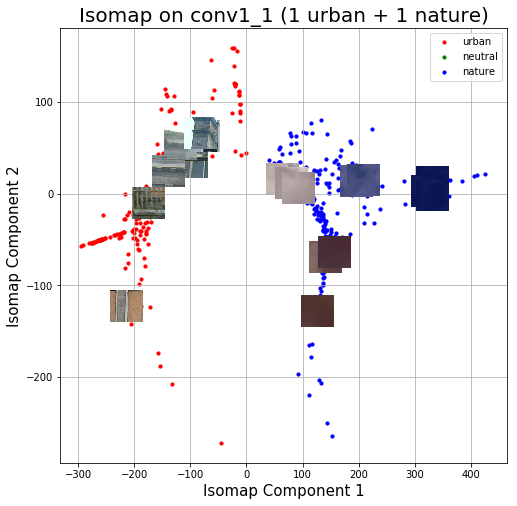

In [194]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Isomap Component 1', fontsize = 15)
ax.set_ylabel('Isomap Component 2', fontsize = 15)
ax.set_title('Isomap on conv1_1 (1 urban + 1 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

all_images = most_urbans + most_natures

for i in range(20):
    img_num = np.random.randint(0, merge_df.shape[0])
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

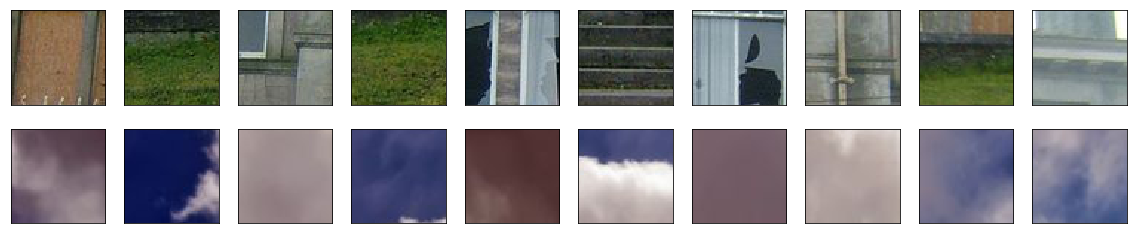

In [195]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

### t-SNE

In [196]:
from sklearn.manifold import TSNE 
tsne = TSNE(n_components=2, n_iter=300)
components = tsne.fit_transform(x)

In [197]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

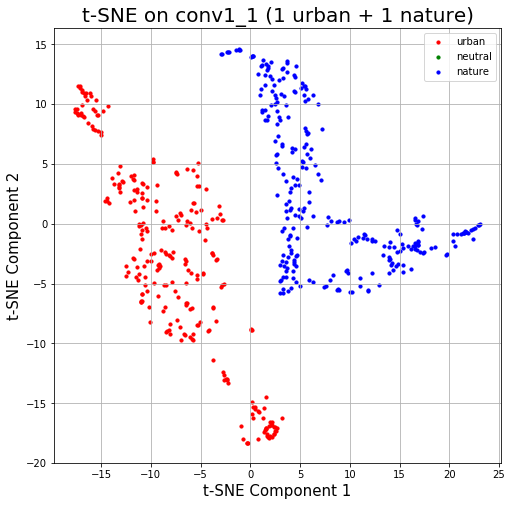

In [198]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('t-SNE Component 1', fontsize = 15)
ax.set_ylabel('t-SNE Component 2', fontsize = 15)
ax.set_title('t-SNE on conv1_1 (1 urban + 1 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

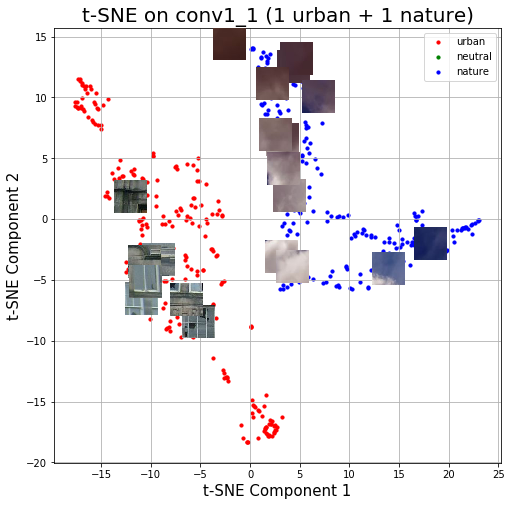

In [199]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('t-SNE Component 1', fontsize = 15)
ax.set_ylabel('t-SNE Component 2', fontsize = 15)
ax.set_title('t-SNE on conv1_1 (1 urban + 1 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

all_images = most_urbans + most_natures

for i in range(20):
    img_num = np.random.randint(0, merge_df.shape[0])
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

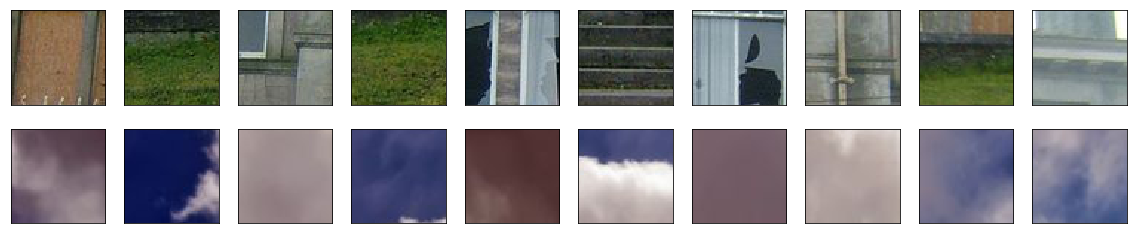

In [200]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

## 5 Urban + 5 Nature + Conv1_1

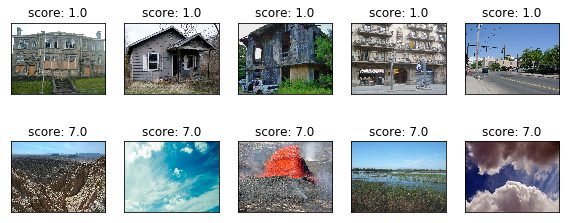

In [75]:
fig = plt.figure(figsize = (20, 4))
for i, image in enumerate(most_urbans):
    image_path = os.path.join(PATH, IMAGEPATH, image[1])
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [], title = "score: {}".format(image[0]))
    plt.imshow(plt.imread(image_path))

for i, image in enumerate(most_natures):
    image_path = os.path.join(PATH, IMAGEPATH, image[1])
    fig.add_subplot(2, 10, i + 11, yticks = [], xticks = [], title = "score: {}".format(image[0]))
    plt.imshow(plt.imread(image_path))
plt.show()

### PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(x)

In [ ]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

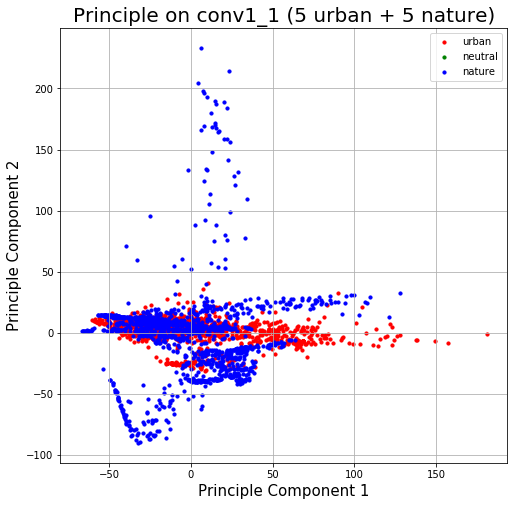

In [125]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principle Component 1', fontsize = 15)
ax.set_ylabel('Principle Component 2', fontsize = 15)
ax.set_title('Principle on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

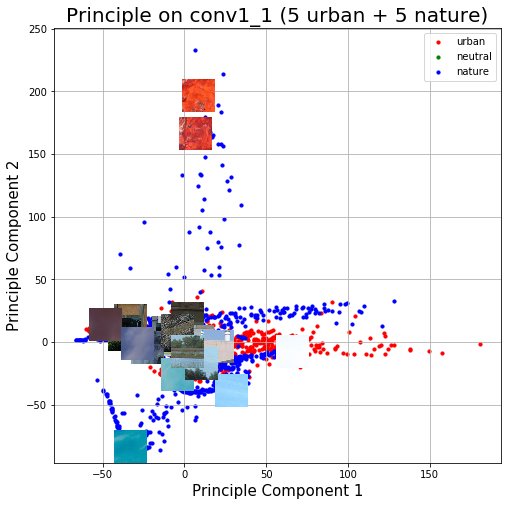

In [132]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principle Component 1', fontsize = 15)
ax.set_ylabel('Principle Component 2', fontsize = 15)
ax.set_title('Principle on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

chosen_patches = []
interval = merge_df.shape[0] // 20

for i in range(20):
    img_num = np.random.randint(i * interval, (i + 1) * interval)  # choose uniformly from each image
    #print("img_num: {}".format(img_num))
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    #print("img id: {} patch num: {}".format(img_id, img_num))
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    chosen_patches.append(img)
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

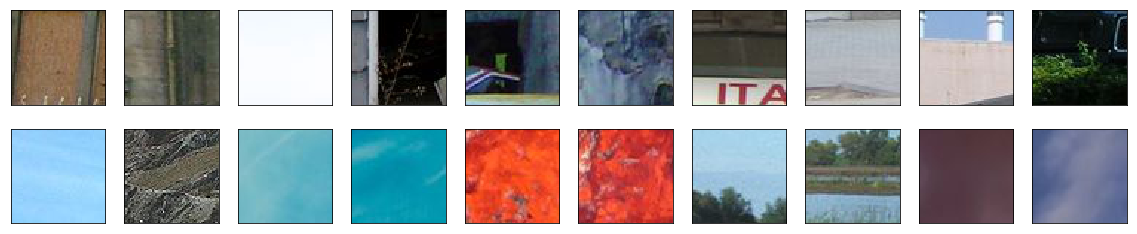

In [133]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

### ICA

In [ ]:
from sklearn.decomposition import FastICA 
ICA = FastICA(n_components=2, random_state=12) 
components = ICA.fit_transform(x)

In [ ]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

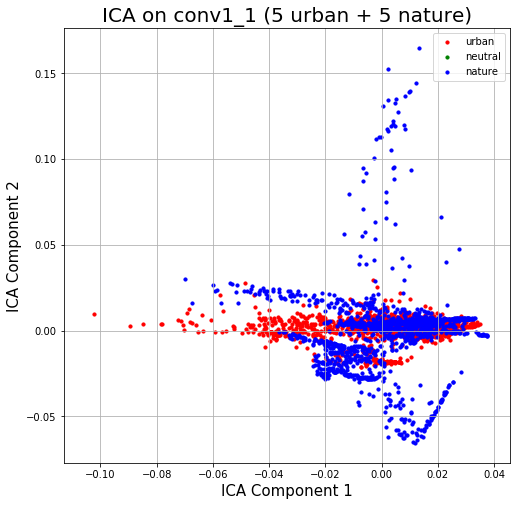

In [137]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('ICA Component 1', fontsize = 15)
ax.set_ylabel('ICA Component 2', fontsize = 15)
ax.set_title('ICA on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

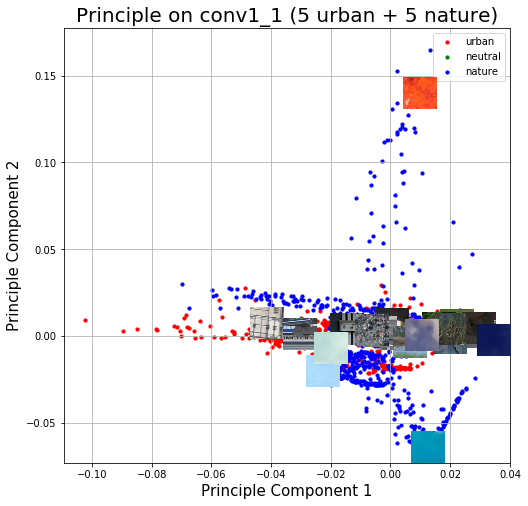

In [139]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principle Component 1', fontsize = 15)
ax.set_ylabel('Principle Component 2', fontsize = 15)
ax.set_title('Principle on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

chosen_patches = []
interval = merge_df.shape[0] // 20

for i in range(20):
    img_num = np.random.randint(i * interval, (i + 1) * interval)  # choose uniformly from each image
    #print("img_num: {}".format(img_num))
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    #print("img id: {} patch num: {}".format(img_id, img_num))
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    chosen_patches.append(img)
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

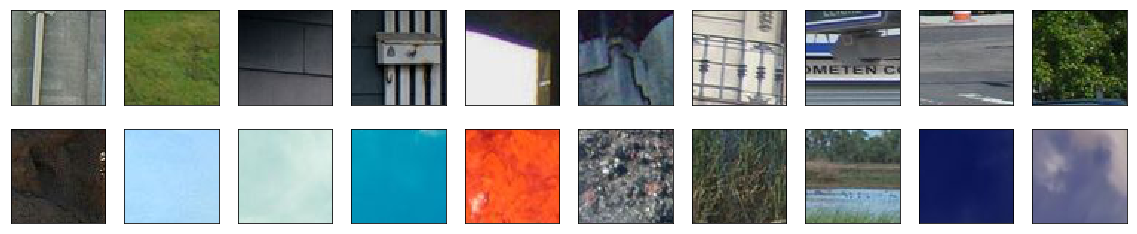

In [140]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

### Factor Analysis

In [142]:
from sklearn.decomposition import FactorAnalysis
FA= FactorAnalysis(n_components = 2)
components = FA.fit_transform(x)

In [143]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])

In [144]:
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

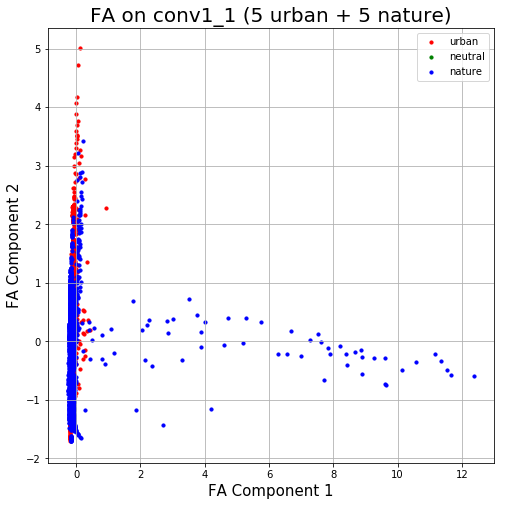

In [147]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('FA Component 1', fontsize = 15)
ax.set_ylabel('FA Component 2', fontsize = 15)
ax.set_title('FA on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

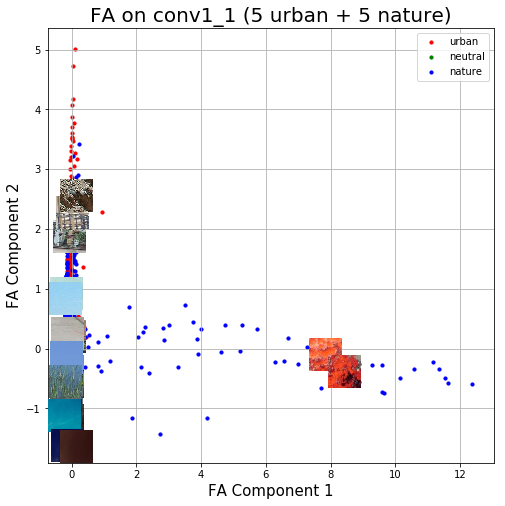

In [148]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('FA Component 1', fontsize = 15)
ax.set_ylabel('FA Component 2', fontsize = 15)
ax.set_title('FA on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

chosen_patches = []
interval = merge_df.shape[0] // 20

for i in range(20):
    img_num = np.random.randint(i * interval, (i + 1) * interval)  # choose uniformly from each image
    #print("img_num: {}".format(img_num))
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    #print("img id: {} patch num: {}".format(img_id, img_num))
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    chosen_patches.append(img)
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

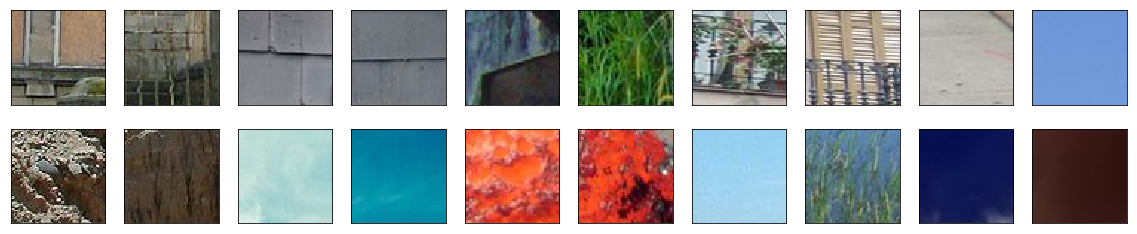

In [149]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

### Isomap

In [155]:
from sklearn import manifold
IM = manifold.Isomap(n_neighbors=5, n_components=2, n_jobs=-1)
components = IM.fit_transform(x)

In [156]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])

In [157]:
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

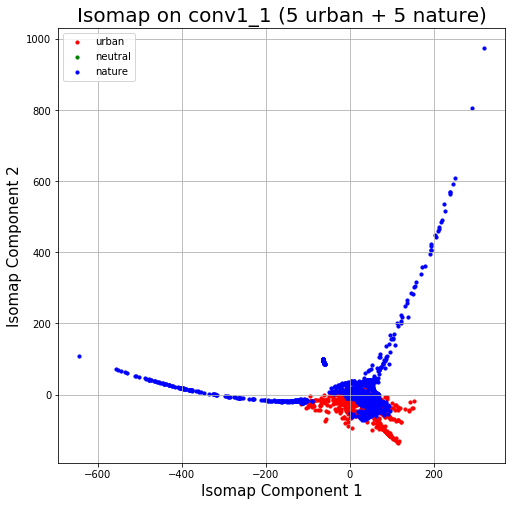

In [158]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Isomap Component 1', fontsize = 15)
ax.set_ylabel('Isomap Component 2', fontsize = 15)
ax.set_title('Isomap on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

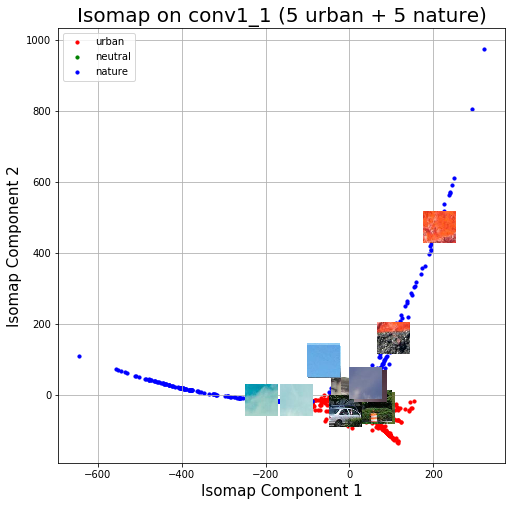

In [112]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Isomap Component 1', fontsize = 15)
ax.set_ylabel('Isomap Component 2', fontsize = 15)
ax.set_title('Isomap on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

chosen_patches = []
interval = merge_df.shape[0] // 20

for i in range(20):
    img_num = np.random.randint(i * interval, (i + 1) * interval)  # choose uniformly from each image
    #print("img_num: {}".format(img_num))
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    #print("img id: {} patch num: {}".format(img_id, img_num))
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    chosen_patches.append(img)
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

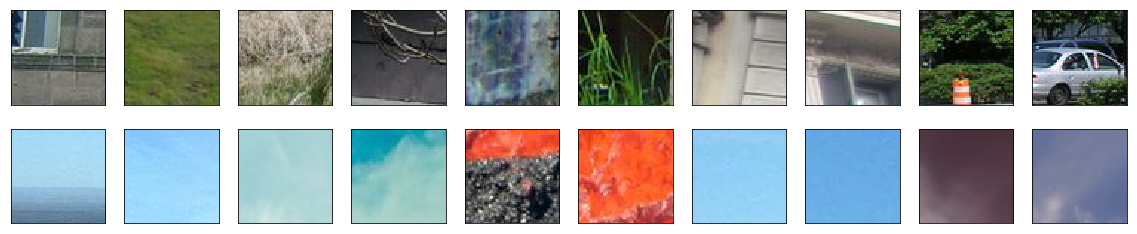

In [113]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

### t-SNE (slow)

In [159]:
from sklearn.manifold import TSNE 
tsne = TSNE(n_components=2, n_iter=300)
components = tsne.fit_transform(x)

In [160]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])

In [161]:
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

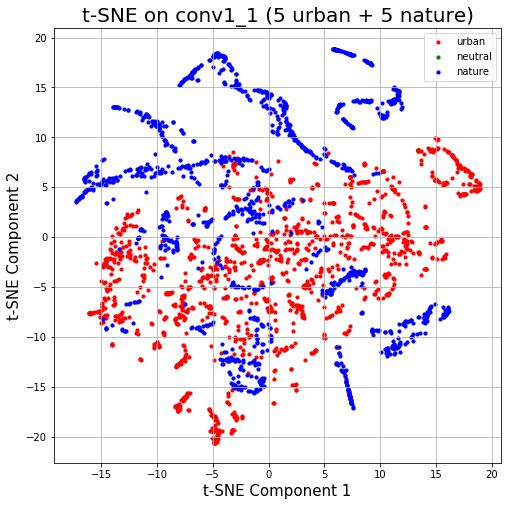

In [162]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('t-SNE Component 1', fontsize = 15)
ax.set_ylabel('t-SNE Component 2', fontsize = 15)
ax.set_title('t-SNE on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

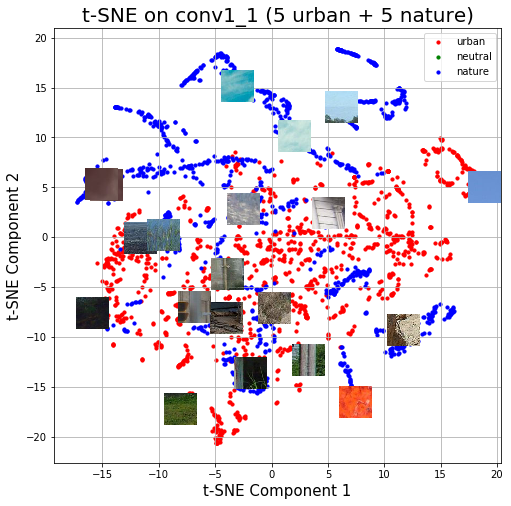

In [163]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('t-SNE Component 1', fontsize = 15)
ax.set_ylabel('t-SNE Component 2', fontsize = 15)
ax.set_title('t-SNE on conv1_1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

chosen_patches = []
interval = merge_df.shape[0] // 20

for i in range(20):
    img_num = np.random.randint(i * interval, (i + 1) * interval)  # choose uniformly from each image
    #print("img_num: {}".format(img_num))
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    #print("img id: {} patch num: {}".format(img_id, img_num))
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    chosen_patches.append(img)
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

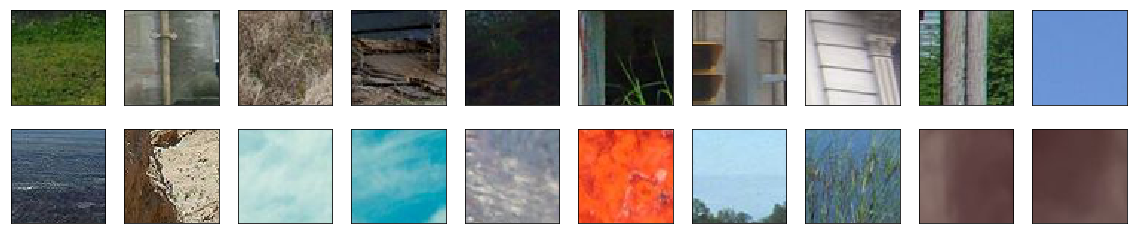

In [164]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

## 5 Urban + 5 Nature + Pool1

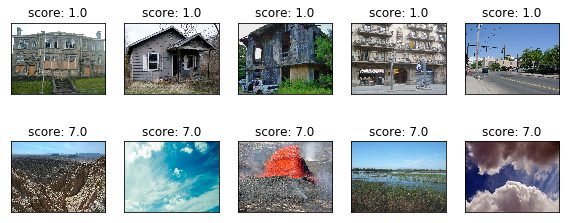

In [223]:
fig = plt.figure(figsize = (20, 4))
for i, image in enumerate(most_urbans):
    image_path = os.path.join(PATH, IMAGEPATH, image[1])
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [], title = "score: {}".format(image[0]))
    plt.imshow(plt.imread(image_path))

for i, image in enumerate(most_natures):
    image_path = os.path.join(PATH, IMAGEPATH, image[1])
    fig.add_subplot(2, 10, i + 11, yticks = [], xticks = [], title = "score: {}".format(image[0]))
    plt.imshow(plt.imread(image_path))
plt.show()

### PCA

In [224]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(x)

In [225]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

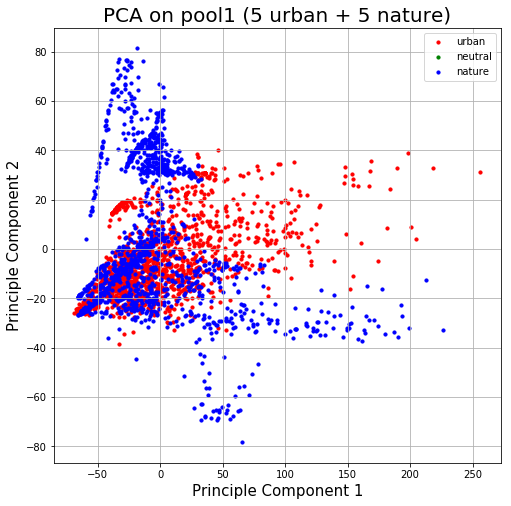

In [226]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principle Component 1', fontsize = 15)
ax.set_ylabel('Principle Component 2', fontsize = 15)
ax.set_title('PCA on pool1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

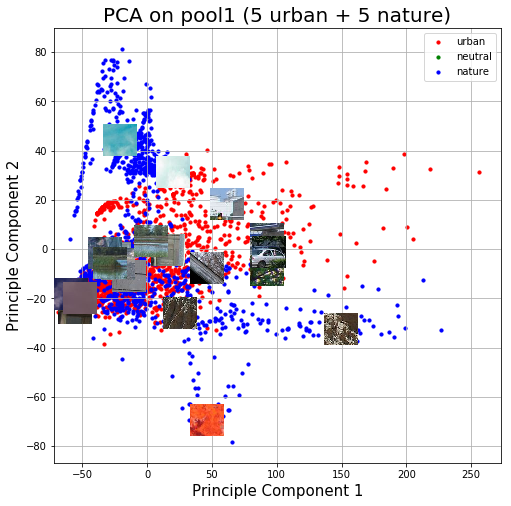

In [236]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principle Component 1', fontsize = 15)
ax.set_ylabel('Principle Component 2', fontsize = 15)
ax.set_title('PCA on pool1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

chosen_patches = []
interval = merge_df.shape[0] // 20

for i in range(20):
    img_num = np.random.randint(i * interval, (i + 1) * interval)  # choose uniformly from each image
    #print("img_num: {}".format(img_num))
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    #print("img id: {} patch num: {}".format(img_id, img_num))
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    chosen_patches.append(img)
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

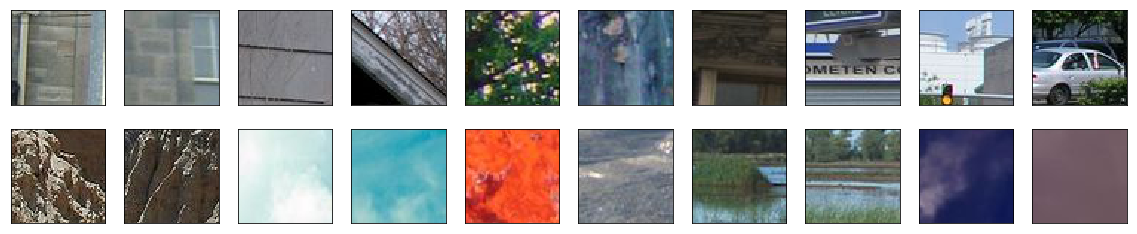

In [237]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

### ICA

In [238]:
from sklearn.decomposition import FastICA 
ICA = FastICA(n_components=2, random_state=12) 
components = ICA.fit_transform(x)

In [239]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

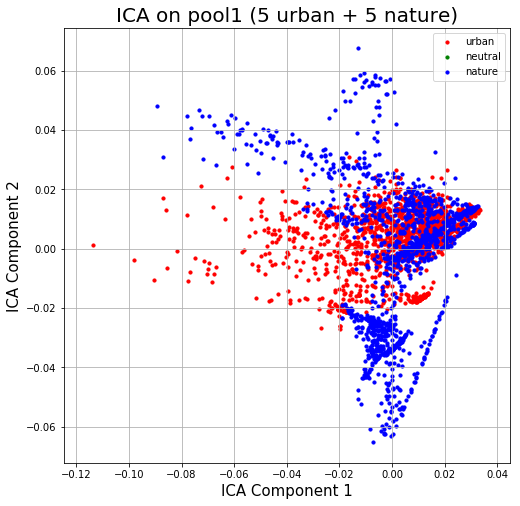

In [240]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('ICA Component 1', fontsize = 15)
ax.set_ylabel('ICA Component 2', fontsize = 15)
ax.set_title('ICA on pool1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

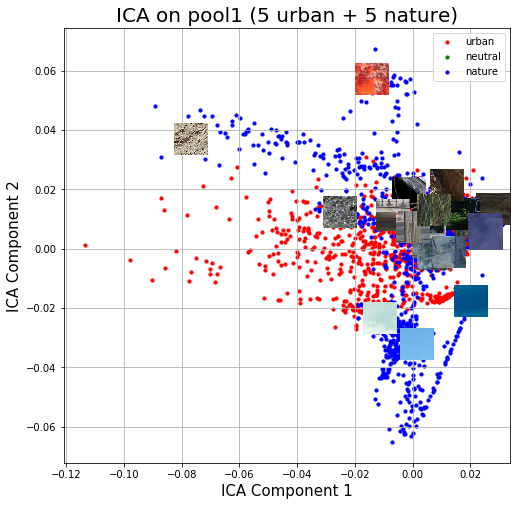

In [251]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('ICA Component 1', fontsize = 15)
ax.set_ylabel('ICA Component 2', fontsize = 15)
ax.set_title('ICA on pool1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

chosen_patches = []
interval = merge_df.shape[0] // 20

for i in range(20):
    img_num = np.random.randint(i * interval, (i + 1) * interval)  # choose uniformly from each image
    #print("img_num: {}".format(img_num))
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    #print("img id: {} patch num: {}".format(img_id, img_num))
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    chosen_patches.append(img)
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

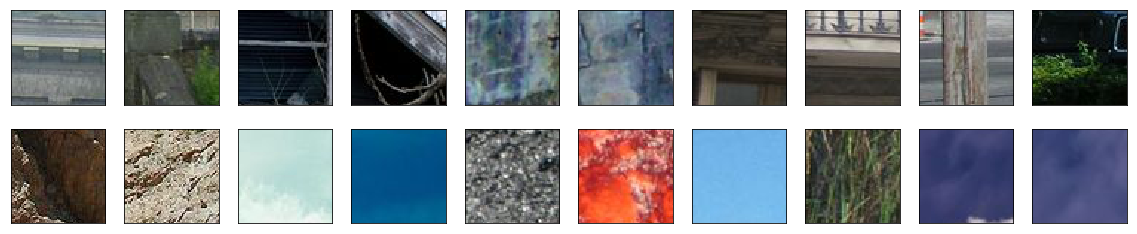

In [252]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

### Isomap

In [253]:
from sklearn import manifold
IM = manifold.Isomap(n_neighbors=5, n_components=2, n_jobs=-1)
components = IM.fit_transform(x)

In [254]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

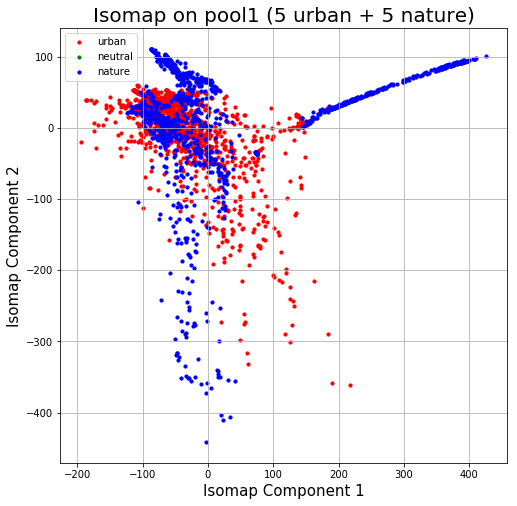

In [255]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Isomap Component 1', fontsize = 15)
ax.set_ylabel('Isomap Component 2', fontsize = 15)
ax.set_title('Isomap on pool1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

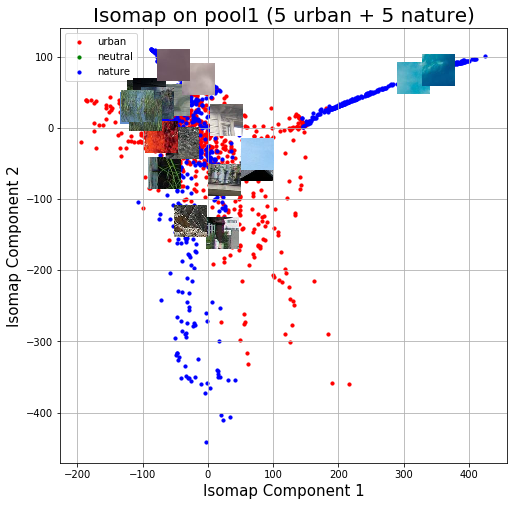

In [272]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Isomap Component 1', fontsize = 15)
ax.set_ylabel('Isomap Component 2', fontsize = 15)
ax.set_title('Isomap on pool1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

chosen_patches = []
interval = merge_df.shape[0] // 20

for i in range(20):
    img_num = np.random.randint(i * interval, (i + 1) * interval)  # choose uniformly from each image
    #print("img_num: {}".format(img_num))
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    #print("img id: {} patch num: {}".format(img_id, img_num))
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    chosen_patches.append(img)
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

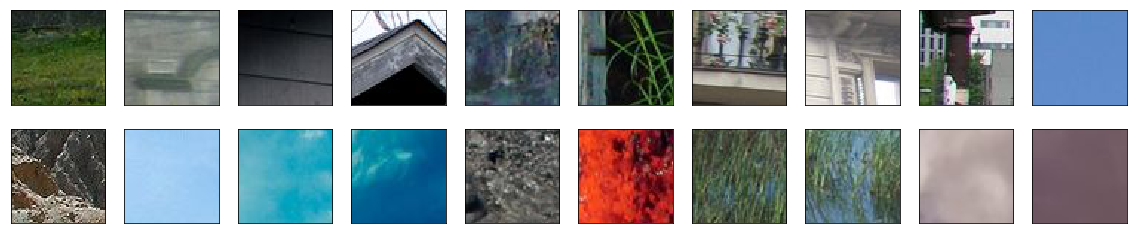

In [273]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

### t-SNE

In [274]:
from sklearn.manifold import TSNE 
tsne = TSNE(n_components=2, n_iter=300)
components = tsne.fit_transform(x)

In [275]:
components_df = pd.DataFrame(data = components, columns = ['principle component 1', 'principle component 2'])
merge_df = pd.concat([components_df, grams_df[['class']]], axis = 1)

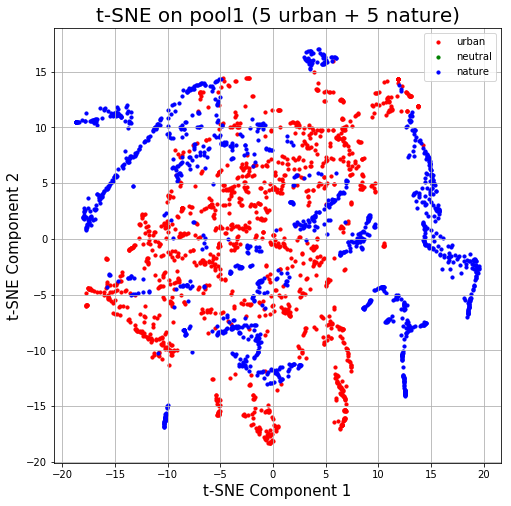

In [276]:
# plot clusters with
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('t-SNE Component 1', fontsize = 15)
ax.set_ylabel('t-SNE Component 2', fontsize = 15)
ax.set_title('t-SNE on pool1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

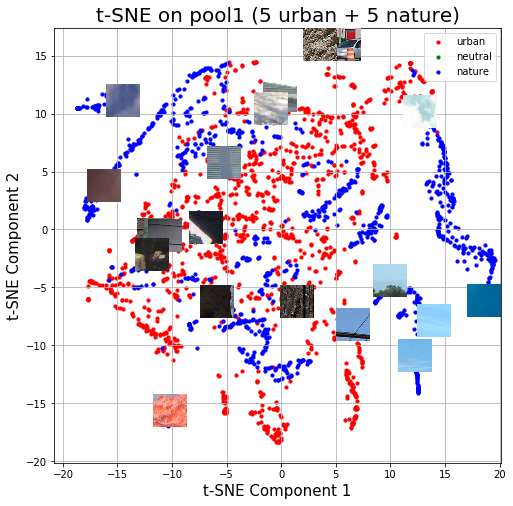

In [279]:
# plot clusters with sample patches
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('t-SNE Component 1', fontsize = 15)
ax.set_ylabel('t-SNE Component 2', fontsize = 15)
ax.set_title('t-SNE on pool1 (5 urban + 5 nature)', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']
    
x_size = (max(merge_df['principle component 1']) - min(merge_df['principle component 1'])) * 0.08
y_size = (max(merge_df['principle component 2']) - min(merge_df['principle component 2'])) * 0.08

chosen_patches = []
interval = merge_df.shape[0] // 20

for i in range(20):
    img_num = np.random.randint(i * interval, (i + 1) * interval)  # choose uniformly from each image
    #print("img_num: {}".format(img_num))
    x0 = merge_df.loc[img_num, 'principle component 1'] - (x_size / 2.)
    y0 = merge_df.loc[img_num, 'principle component 2'] - (y_size / 2.)
    x1 = merge_df.loc[img_num, 'principle component 1'] + (x_size / 2.)
    y1 = merge_df.loc[img_num, 'principle component 2'] + (y_size / 2.)
    img_id, img_num = img_num // (PROW * PCOL), img_num % (PROW * PCOL)
    irow, icol = compute_patches_row_col(img_num)
    #print("img id: {} patch num: {}".format(img_id, img_num))
    img = patches[img_id][irow][icol]
    ax.imshow(img, aspect = "auto", interpolation='nearest', zorder = 100000, extent = (x0, x1, y0, y1))
    chosen_patches.append(img)
    
for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
    
ax.legend(classes)
ax.grid()

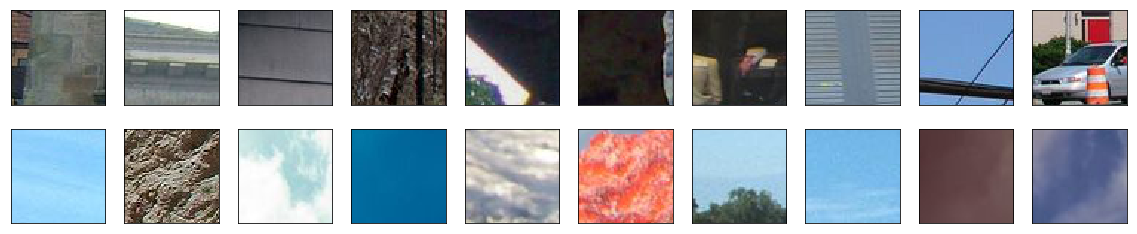

In [280]:
# chosen patches
fig = plt.figure(figsize = (20, 4))
for i, patch in enumerate(chosen_patches):
    fig.add_subplot(2, 10, i + 1, yticks = [], xticks = [])
    plt.imshow(patch)
plt.show()

## Some previous trials

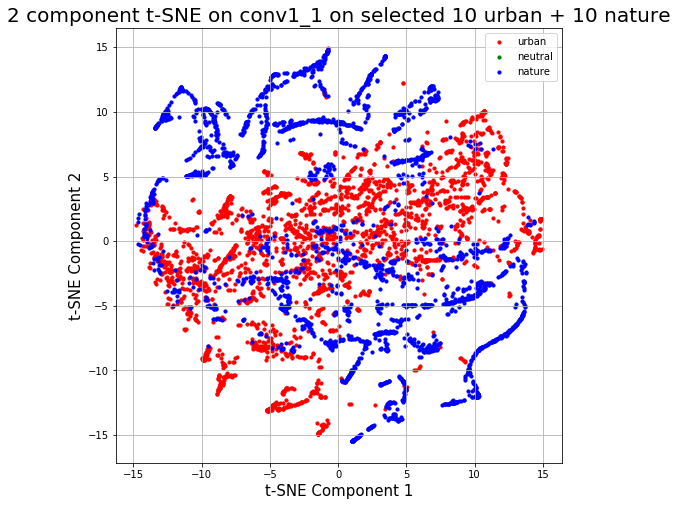

In [106]:
# plot clusters
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('t-SNE Component 1', fontsize = 15)
ax.set_ylabel('t-SNE Component 2', fontsize = 15)
ax.set_title('2 component t-SNE on conv1_1 on selected 10 urban + 10 nature', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

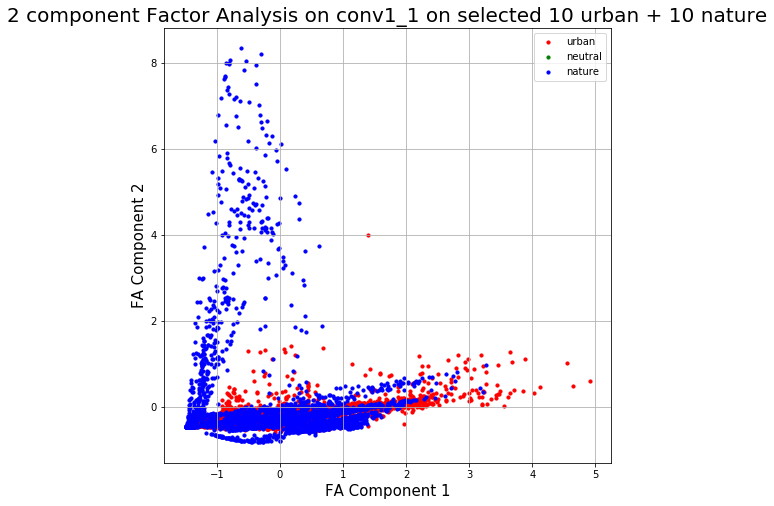

In [98]:
# plot clusters
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('FA Component 1', fontsize = 15)
ax.set_ylabel('FA Component 2', fontsize = 15)
ax.set_title('2 component Factor Analysis on conv1_1 on selected 10 urban + 10 nature', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

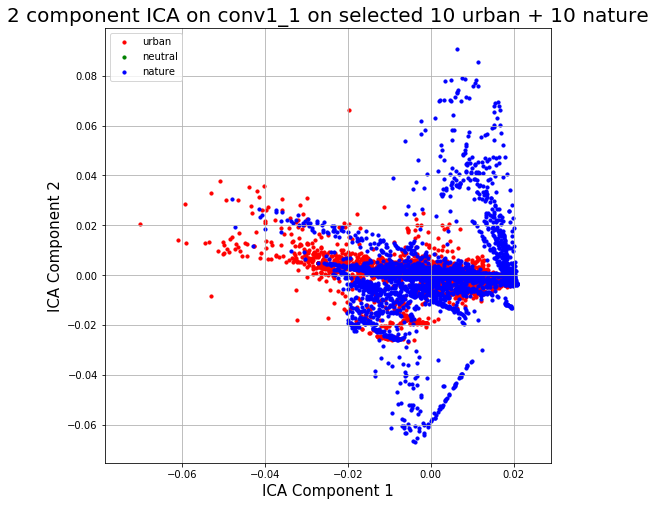

In [81]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('ICA Component 1', fontsize = 15)
ax.set_ylabel('ICA Component 2', fontsize = 15)
ax.set_title('2 component ICA on conv1_1 on selected 10 urban + 10 nature', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

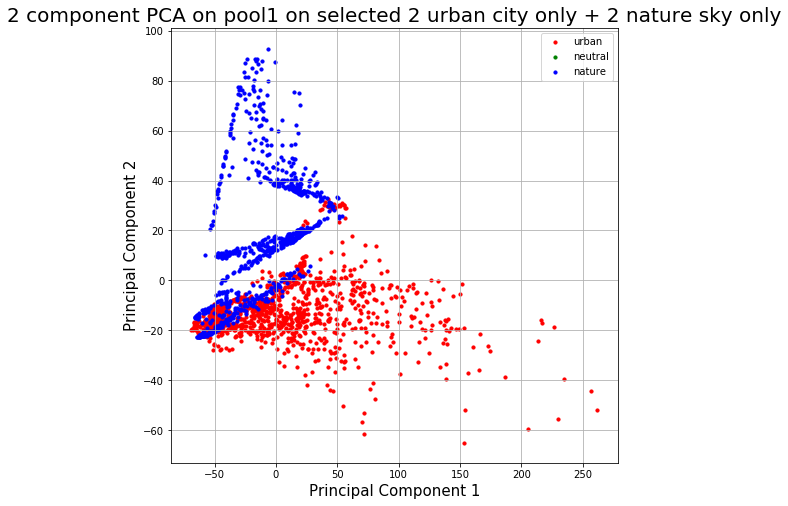

In [332]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool1 on selected 2 urban city only + 2 nature sky only', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

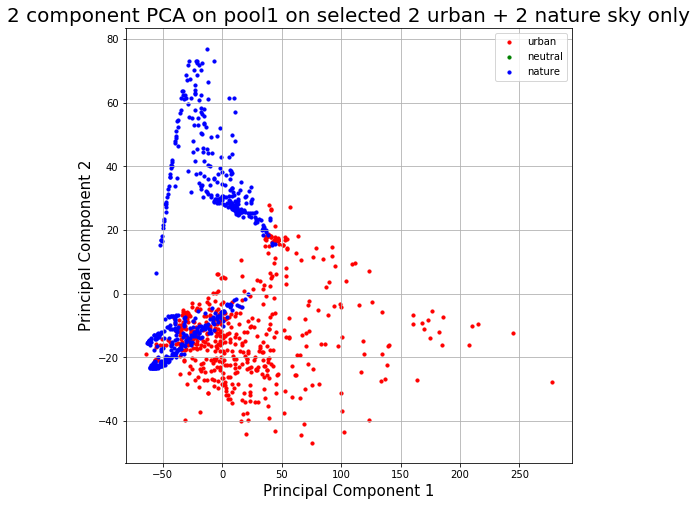

In [238]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool1 on selected 2 urban + 2 nature sky only', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

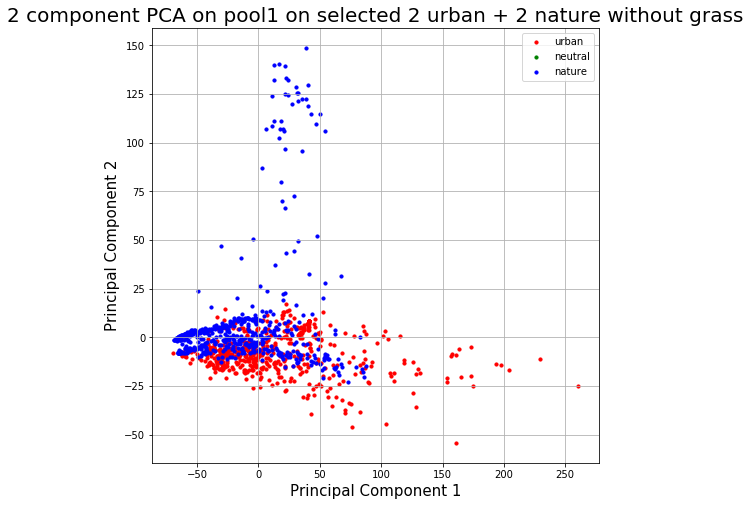

In [227]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool1 on selected 2 urban + 2 nature without grass', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [228]:
# check variance ratio
pca.explained_variance_ratio_

array([0.51555666, 0.14812595])

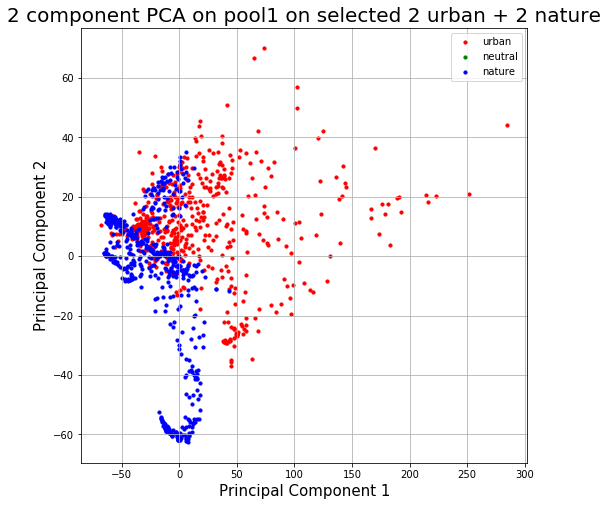

In [211]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool1 on selected 2 urban + 2 nature', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

Now the data points start to get mixed -- probably because we now use a nature image with "grass" -- also appear frequently in urban images

In [212]:
# check variance ratio
pca.explained_variance_ratio_

array([0.51345132, 0.14242582])

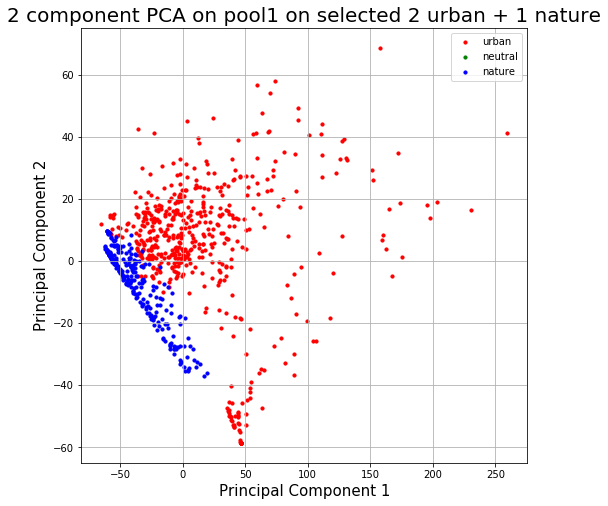

In [201]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool1 on selected 2 urban + 1 nature', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [202]:
# check variance ratio
pca.explained_variance_ratio_

array([0.57547554, 0.11386467])

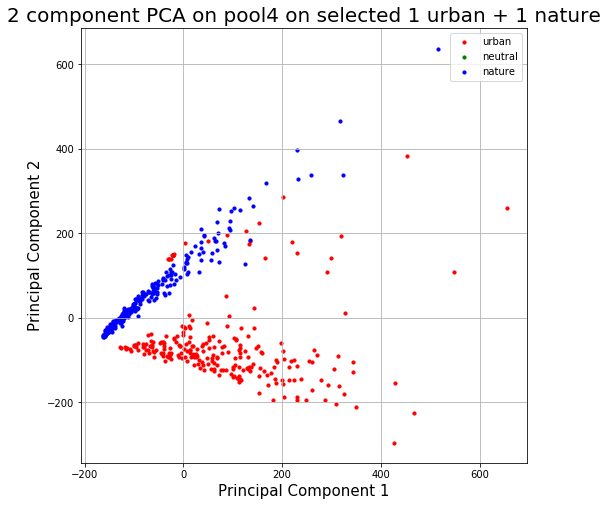

In [190]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool4 on selected 1 urban + 1 nature', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [191]:
# check variance ratio
pca.explained_variance_ratio_

array([0.06957401, 0.04814406])

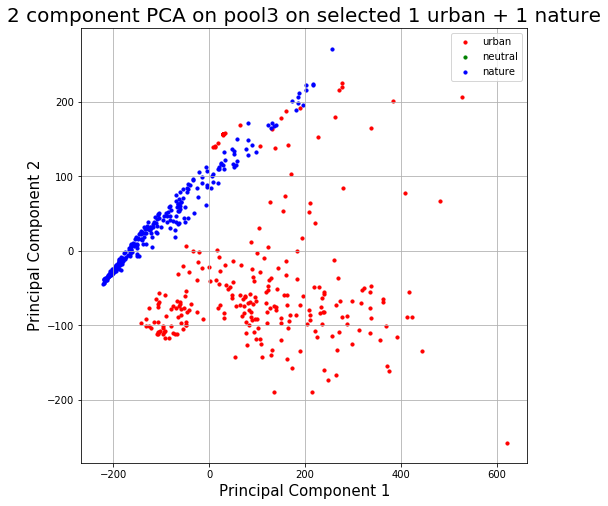

In [182]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool3 on selected 1 urban + 1 nature', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [183]:
# check variance ratio
pca.explained_variance_ratio_

array([0.41216267, 0.1231929 ])

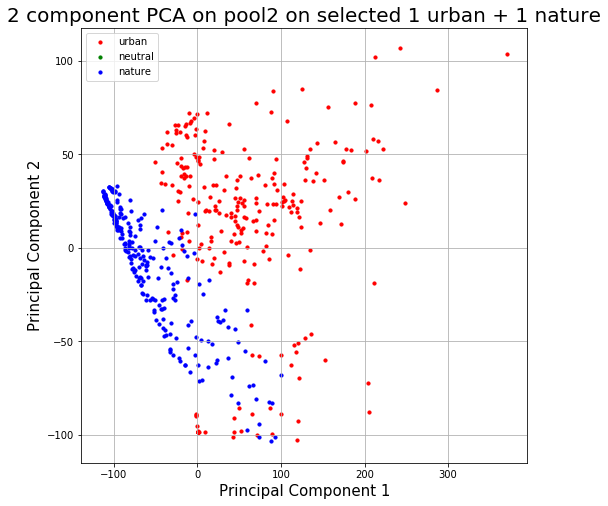

In [174]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool2 on selected 1 urban + 1 nature', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [175]:
# check variance ratio
pca.explained_variance_ratio_

array([0.4352774 , 0.12165139])

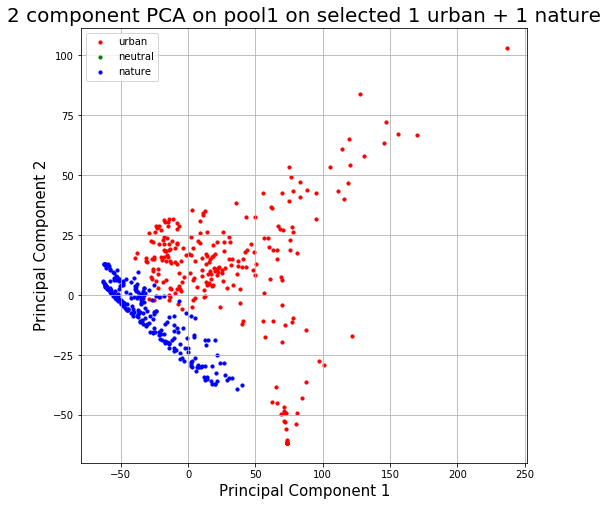

In [166]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool1 on selected 1 urban + 1 nature', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [167]:
# check variance ratio
pca.explained_variance_ratio_

array([0.57965767, 0.14989341])

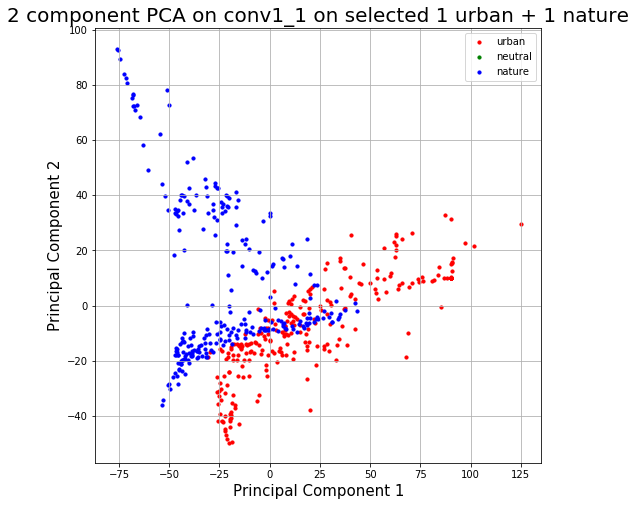

In [158]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on conv1_1 on selected 1 urban + 1 nature', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [159]:
# check variance ratio
pca.explained_variance_ratio_

array([0.41445845, 0.1587266 ])

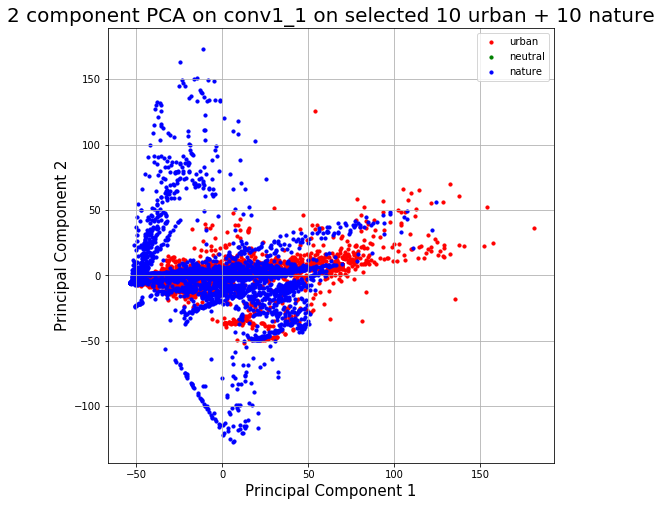

In [41]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on conv1_1 on selected 10 urban + 10 nature', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [42]:
# check variance ratio
pca.explained_variance_ratio_

array([0.30136285, 0.16682748])

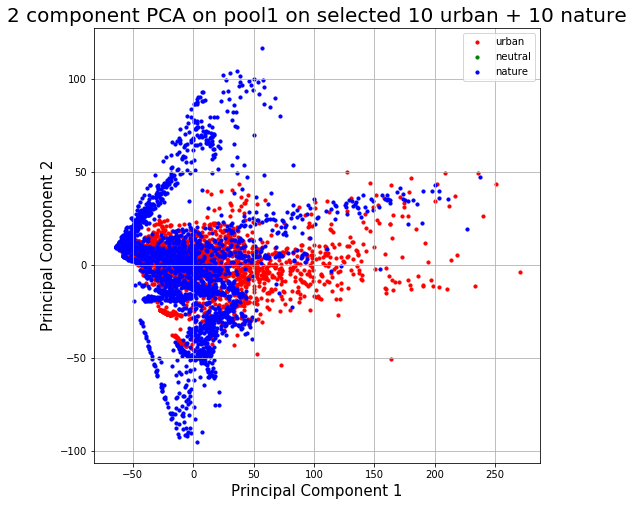

In [31]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool1 on selected 10 urban + 10 nature', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [32]:
# check variance ratio
pca.explained_variance_ratio_

array([0.49724856, 0.13582769])

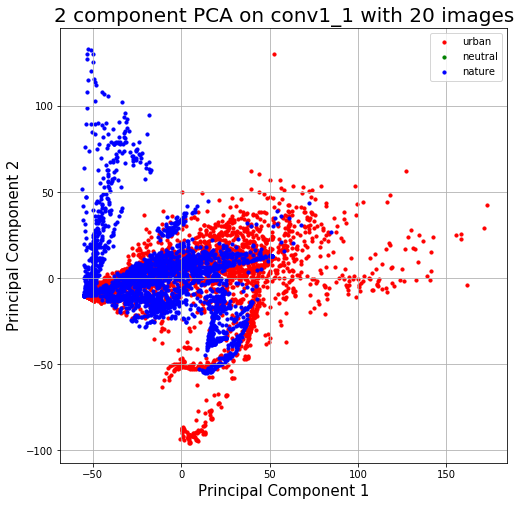

In [183]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on conv1_1 with 20 images', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [178]:
# check variance ratio
pca.explained_variance_ratio_

array([0.31146847, 0.14955272])

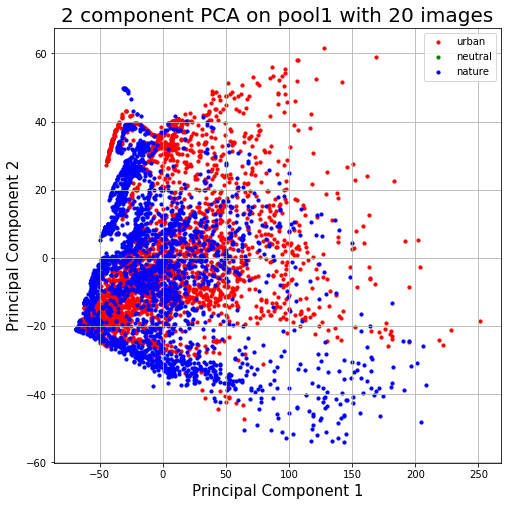

In [194]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool1 with 20 images', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [195]:
# check variance ratio
pca.explained_variance_ratio_

array([0.54805367, 0.10944992])

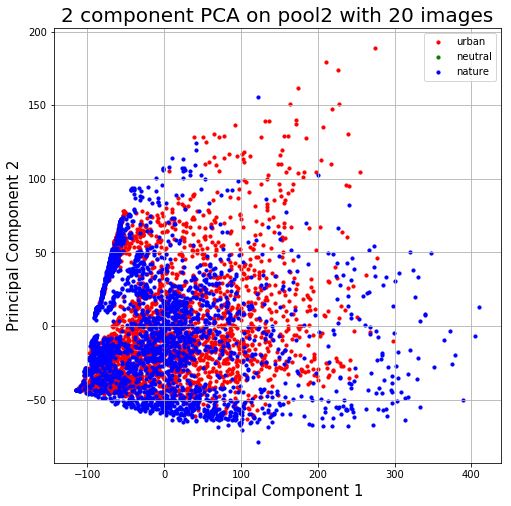

In [204]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool2 with 20 images', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [205]:
# check variance ratio
pca.explained_variance_ratio_

array([0.4282739 , 0.10036235])

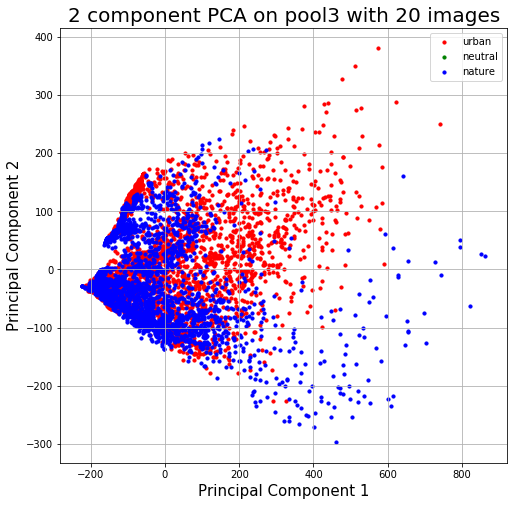

In [214]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool3 with 20 images', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [215]:
# check variance ratio
pca.explained_variance_ratio_

array([0.36866808, 0.11255831])

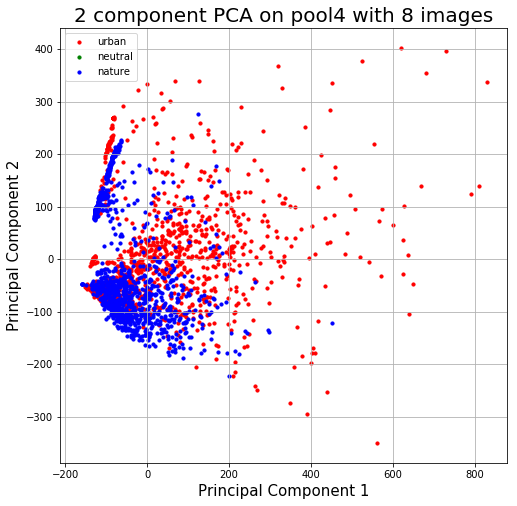

In [13]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool4 with 8 images', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [14]:
# check variance ratio
pca.explained_variance_ratio_

array([0.0697191, 0.0463415])

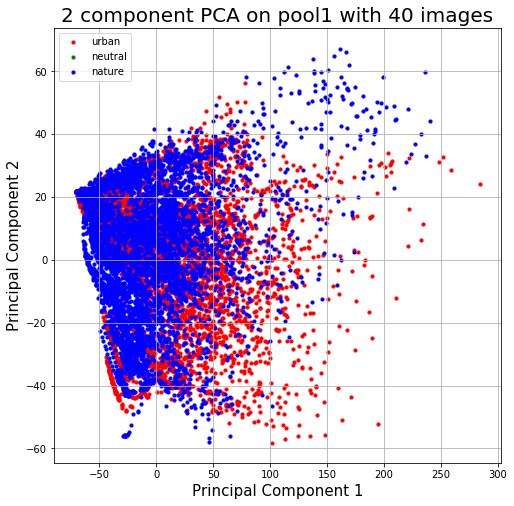

In [23]:
# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA on pool1 with 40 images', fontsize = 20)

classes = CLASSES[:]
colors = ['r', 'g', 'b']

for cls, color in zip(classes, colors):
    inds = merge_df['class'] == cls
    to_keep = merge_df.loc[inds, 'principle component 1']
    ax.scatter(merge_df.loc[inds, 'principle component 1'], merge_df.loc[inds, 'principle component 2'], \
            c = color, s = 10)
ax.legend(classes)
ax.grid()

In [24]:
# check variance ratio
pca.explained_variance_ratio_

array([0.53621315, 0.11401382])